# Rainbow Trout Meat Quality Classification using Genomic Data 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import json

from scipy import stats

%autosave 30

Autosaving every 30 seconds


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Meta Data Creation

In [3]:
# %%time
# metadf_init = pd.read_excel("./data/GeneExpressionData/Meta_data.xlsx", usecols=['genetic line','Orso_Id'])
# print(f"Initial Dataframe Size:{metadf_init.shape}")

# #Dropping rows with NaN values.
# metadf_init.dropna(inplace=True)
# print(f"Dataframe Size post cleaning:{metadf_init.shape}")
# metadf_init.head()

In [4]:
# def processRows(row):
#     geneLine, fishId = row['genetic line'].split('-')[-1], row['Orso_Id'].split('_')[-1]
#     # print(geneLine, fishId)
#     return pd.Series(data = [f"F{fishId}", 'high' if geneLine=='H' else 'low'], index=['FishID', 'GeneLine'])

# metadf_init.apply(processRows, axis=1).to_csv("./metaFishData.csv", index=False)

## Meta Data

In [35]:
metadf = pd.read_csv("./metaFishData.csv")
metadf.head()

,FishID,GeneLine
0,F75,high
1,F66,low
2,F76,high
3,F72,low
4,F78,high


In [36]:
metadf['GeneLine'].value_counts(normalize=True)

GeneLine
high    0.504298
low     0.495702
Name: proportion, dtype: float64

## Metaphlan Profile

In [37]:
%%time
mp_df = pd.read_csv("./data/GeneExpressionData/merged_metaphlan_profile.tsv", sep='\t', header=0).reset_index()
print(f"Metaphlan Profile Data Shape: {mp_df.shape}")

#Generating consistent Fish Identification Marking
fishIdentifierFnx = lambda row: f'F{row.split("_")[3]}'
mp_df.iloc[0, 1:] = mp_df.iloc[0, 1:].apply(fishIdentifierFnx)

#Setting Column Names to the fish identification markings
mp_df.columns = mp_df.iloc[0]
mp_df.drop(mp_df.index[0], inplace=True)
mp_df.head()

Metaphlan Profile Data Shape: (1567, 352)
CPU times: user 238 ms, sys: 11.3 ms, total: 249 ms
Wall time: 246 ms


,clade_name,F100,F101,F102,F103,F104,F105,F106,F107,F108,...,F91,F92,F93,F94,F95,F96,F97,F98,F99,F9
1,k__Bacteria,100.0,99.97197,100.0,100.0,100.0,99.99576,99.98729,100.0,100.0,...,100.0,100.0,99.99293,100.0,100.0,100.0,100.0,100.0,100.0,99.99385
2,k__Bacteria|p__Proteobacteria,96.23163,1.28278,2.46132,4.19295,0.61851,0.09897,7.26275,0.26161,4.19682,...,12.66281,0.96307,18.82358,0.32609,0.02745,0.0,44.74296,0.15063,0.0,0.66998
3,k__Bacteria|p__Fusobacteria,1.90922,0.02158,96.92149,0.24615,91.75045,0.10025,0.05683,43.08036,95.27552,...,82.35353,98.30658,79.81764,36.31168,99.72513,1.57367,17.83804,98.75345,97.18932,79.67032
4,k__Bacteria|p__Firmicutes,1.85915,97.78226,0.4784,87.89138,6.77893,80.14233,92.20322,56.095,0.52766,...,4.60755,0.63897,1.25554,61.489,0.1855,98.42633,34.07137,1.09592,2.81068,18.22957
5,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,95.58687,0.0,1.11736,0.05299,0.0497,0.0,0.00083,0.0,2.79746,...,11.30934,0.37437,18.81727,0.06843,0.0,0.0,44.66672,0.15063,0.0,0.56759


## Clade Family

In [38]:
from treelib import Node, Tree

In [39]:
clade = mp_df.iloc[:, 0]

cladeFnxLambda = lambda row: len(row.split('|'))
clade.apply(cladeFnxLambda).value_counts()

clade_name
8    560
7    539
6    260
5    101
4     54
3     37
2     11
1      4
Name: count, dtype: int64

In [40]:
# cladeFnxLambda = lambda row: row.split('|')
# clade.apply(cladeFnxLambda).value_counts()

In [41]:
%%time
tree = Tree()
tree.create_node('Main', 'main')
def cladeFnxTree(row):
    row = row.split('|')
    if len(row)==1:
        tree.create_node(row[0], row[0], parent='main')
    else:
        tree.create_node(row[-1], row[-1], parent=row[-2])
             
_ = clade.apply(cladeFnxTree)

print("Depth of tree:", tree.depth())
# tree.show()      

Depth of tree: 8
CPU times: user 19.8 ms, sys: 2.14 ms, total: 21.9 ms
Wall time: 19.9 ms


In [53]:
treeFamily = json.loads(tree.to_json(with_data=False))

In [51]:
familyMap = {f'level{r}':[] for r in range(0,8)}

# def cladeFnx(row):
#     row = row.split('|')
#     i = 0
#     for rw in row:
#         familyMap[f'level{i}'].append(rw)
#         i+=1
#     while i<8:
#         familyMap[f'level{i}'].append(None)
#         i+=1

def cladeFnx(row):
    row_ = row.split('|')
    familyMap[f'level{len(row_)-1}'].append(row)
    
    

_ = clade.apply(cladeFnx)

In [57]:
for i in familyMap:
    familyMap[i] = list(set(familyMap[i]))


familyMapRev = {}
for i in familyMap:
    for j in familyMap[i]:
        familyMapRev[j] = i

## Initial Exploration

In [171]:
mp_fin = mp_df.set_index('clade_name').T
mp_fin = mp_fin.apply(pd.to_numeric, downcast='float')

mp_fin = pd.merge(left=mp_fin, right=metadf, left_index=True, right_on='FishID', how='inner').drop('FishID', axis=1)
mp_fin.dropna(inplace=True)
print(mp_fin.shape)

(349, 1567)


In [172]:
mp_fin.head()

,k__Bacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Fusobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria,k__Bacteria|p__Fusobacteria|c__Fusobacteriia,k__Bacteria|p__Firmicutes|c__Bacilli,k__Bacteria|p__Firmicutes|c__Clostridia,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria,k__Bacteria|p__Firmicutes|c__Tissierellia,...,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__SGB16671,k__Eukaryota|p__Basidiomycota,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta|t__EUK76775,GeneLine
181,100.00000,96.231628,1.909220,1.859150,95.586868,1.909220,1.114860,0.742340,0.64476,0.00196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
209,99.97197,1.282780,0.021580,97.782257,0.000000,0.021580,68.893913,27.902140,1.28278,0.60573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
246,100.00000,2.461320,96.921494,0.478400,1.117360,96.921494,0.320890,0.157520,1.34395,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
78,100.00000,4.192950,0.246150,87.891380,0.052990,0.246150,63.512451,24.072491,3.15654,0.19579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
265,100.00000,0.618510,91.750450,6.778930,0.049700,91.750450,5.072790,1.677510,0.56792,0.02729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high


### Outlier Analysis

In [62]:
mp_fin.iloc[:, :].shape

(351, 1567)

In [63]:
# Number of outliers in each column
def outliersFnx(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return len(data[s>m])

In [64]:
fnx = lambda row: type(row.values)
fnx = lambda row: outliersFnx(row.values)
outlierCount = mp_fin.iloc[:, :-1].apply(fnx, axis=0).values

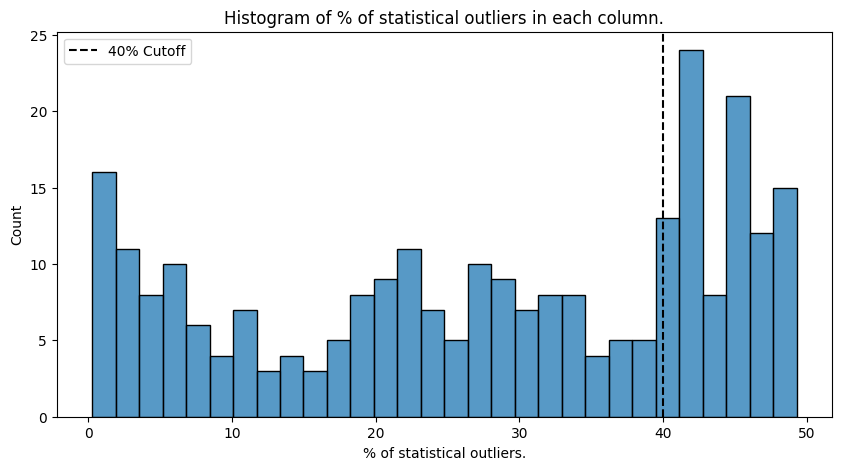

In [65]:
OUTLIER_CUTOFF = 40
plt.figure(figsize=(10,5), dpi = 100)
sns.histplot(data=outlierCount[outlierCount!=0]*100/(mp_df.shape[1]-1), bins=30)
plt.axvline(x=OUTLIER_CUTOFF, color='black', linestyle='--', label='40% Cutoff')
plt.legend()
plt.title("Histogram of % of statistical outliers in each column.")
plt.xlabel("% of statistical outliers.")
plt.show()

The dashed vertical lines represents the cutoff mark, beyond which there are features with more than the cutoff statistical outlier values.

In [66]:
var_ = outlierCount*100/(mp_df.shape[1]-1)
len(var_[var_>40])

print(f"{len(var_[var_>40])} out of {len(var_)} features have more than {OUTLIER_CUTOFF}% datapoints as statistical outliers.")

89 out of 1566 features have more than 40% datapoints as statistical outliers.


In [67]:
hmap = {'feature':[], 'outlierCount':[], 'outlierCount%':[], 'level':[]}
for i,j  in zip(mp_fin.columns, outlierCount):
    hmap['feature'].append(i)
    hmap['outlierCount'].append(j)
    hmap['outlierCount%'].append(j*100/mp_df.shape[1])
    hmap['level'].append(len(i.split('|')))
    
outlierDf = pd.DataFrame(hmap)

In [68]:
outlierDf[outlierDf['outlierCount%']>OUTLIER_CUTOFF].head()

,feature,outlierCount,outlierCount%,level
2,k__Bacteria|p__Fusobacteria,149,42.329545,2
5,k__Bacteria|p__Fusobacteria|c__Fusobacteriia,149,42.329545,3
10,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,149,42.329545,4
11,k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o...,149,42.329545,4
14,k__Bacteria|p__Proteobacteria|c__Betaproteobac...,151,42.897727,4


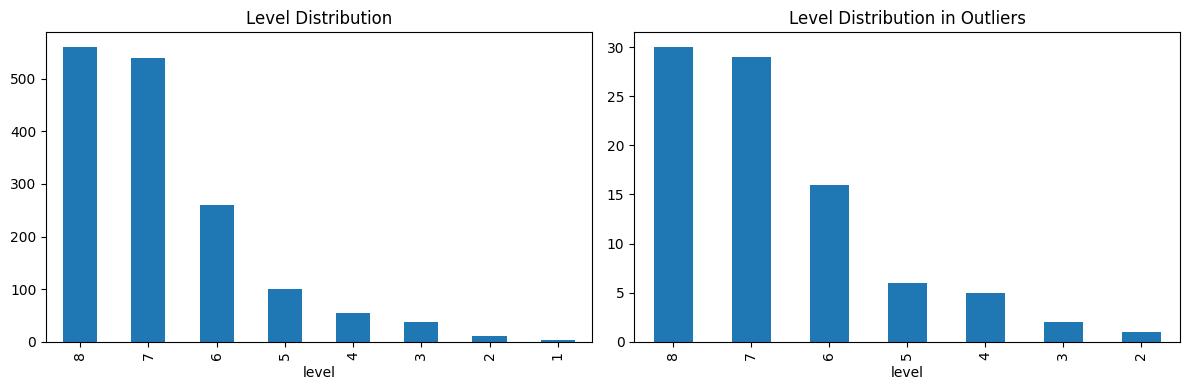

In [188]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=False)
outlierDf['level'].value_counts().plot(kind='bar', ax=ax[0])
outlierDf[outlierDf['outlierCount%']>OUTLIER_CUTOFF]['level'].value_counts().plot(kind='bar', ax=ax[1])

ax[0].set_title('Level Distribution')
ax[1].set_title('Level Distribution in Outliers')
plt.tight_layout()
plt.show()

In [70]:
# Variance
mp_fin.groupby('GeneLine').var()

,k__Bacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Fusobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria,k__Bacteria|p__Fusobacteria|c__Fusobacteriia,k__Bacteria|p__Firmicutes|c__Bacilli,k__Bacteria|p__Firmicutes|c__Clostridia,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria,k__Bacteria|p__Firmicutes|c__Tissierellia,...,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Corynebacteriales|f__Nocardiaceae|g__Nocardia|s__Nocardia_sp_MH4|t__SGB110840,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__SGB16671,k__Eukaryota|p__Basidiomycota,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta|t__EUK76775
GeneLine,,,,,,,,,,,,,,,,,,,,,
high,56.823914,487.603302,1537.609985,1628.704468,417.994019,1537.609985,944.691772,132.518997,96.790024,0.029175,...,0.0,0.000000e+00,0.000000e+00,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07
low,58.872547,492.462921,1539.468384,1597.708740,360.880737,1539.468384,949.266174,178.377335,139.633316,0.023393,...,0.0,1.406705e-08,1.406705e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [109]:
LEVEL = 'level7'
temp_ = mp_fin.loc[:, familyMap[LEVEL]+['GeneLine']].groupby('GeneLine').mean().T
temp_ = temp_[temp_['high']<30]
temp_.head()

GeneLine,high,low
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_mucifaciens|t__SGB17064,0.000038,0.000000
k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_marcusii|t__SGB10707,0.000012,0.000480
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_oris|t__SGB15881,0.000000,0.000749
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_genitalium|t__SGB17050,0.000000,0.000011
k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Hyphomicrobiales|f__Hyphomicrobiaceae|g__Methyloceanibacter|s__Methyloceanibacter_marginalis|t__SGB10926,0.001127,0.000340


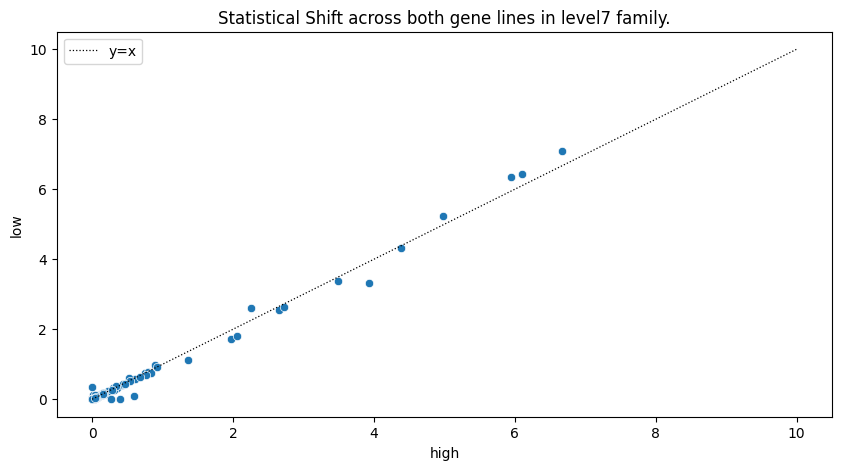

In [124]:
t_ = 10

plt.figure(figsize=(10, 5), dpi = 100)
sns.scatterplot(x=temp_['high'], y=temp_['low'])
plt.plot([0,t_], [0, t_], ls=':', color='black', linewidth = .9, label='y=x')
plt.title(f"Statistical Shift across both gene lines in {LEVEL} family.")
plt.legend()
plt.show()

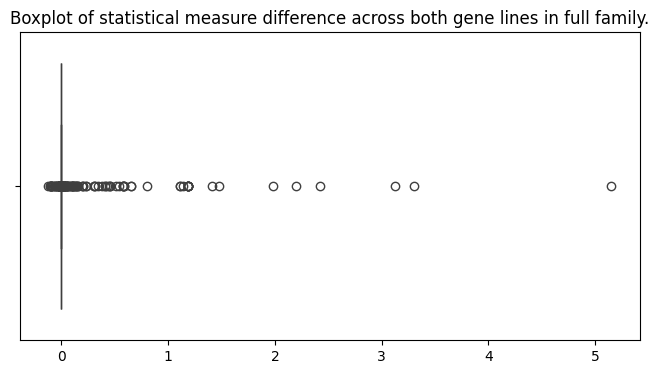

In [143]:
LEVEL = 'full'
temp2_ = mp_fin.groupby('GeneLine').median().T
temp2Diff_ = (temp2_['high']-temp2_['low'])

plt.figure(figsize=(8, 4), dpi = 100)
sns.boxplot(data=temp2Diff_, showfliers=True, orient = 'h')

plt.title(f"Boxplot of statistical measure difference across both gene lines in {LEVEL} family.")
plt.show()

We see that several features are present in the outlier region

In [160]:
# temp2_ = mp_fin.groupby('GeneLine').mean().T
# temp2_ = mp_fin.groupby('GeneLine').median().T
# temp2_ = mp_fin.groupby('GeneLine').var().T
# temp2Diff_ = (temp2_['high']-temp2_['low'])

# outlierDf = pd.merge(left=outlierDf, right = temp2Diff_.rename("statVarDiff"), left_on='feature', right_index=True)

In [159]:
outlierDf.head()

,feature,outlierCount,outlierCount%,level,statMeanDiff,statMedianDiff,statVarDiff
0,k__Bacteria,0,0.000000,1,0.081177,0.000000,-2.048634
1,k__Bacteria|p__Proteobacteria,114,32.386364,2,0.117921,-0.063375,-4.859619
2,k__Bacteria|p__Fusobacteria,149,42.329545,2,-0.604095,1.181850,-1.858398
3,k__Bacteria|p__Firmicutes,0,0.000000,2,0.426384,5.151894,30.995728
4,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,136,38.636364,3,0.595887,-0.074605,57.113281


### Mutual Importance

In [158]:
from sklearn.feature_selection import mutual_info_classif

In [175]:
%%time
# Mutual Information
mi = mutual_info_classif(mp_fin.iloc[:, :-1], mp_fin.iloc[:, -1].replace({'high':1, 'low':0}))

CPU times: user 1.14 s, sys: 16.7 ms, total: 1.15 s
Wall time: 1.15 s


In [176]:
outlierDf = outlierDf.assign(mi=mi)

array([0., 0., 0., ..., 0., 0., 0.])

In [187]:
outlierDf[outlierDf['mi']!=0].sort_values('mi', ascending=False)

,feature,outlierCount,outlierCount%,level,statMeanDiff,statMedianDiff,statVarDiff,mi
527,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0,0.0,8,0.000369,0.0,7.716004e-06,0.094469
505,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,0,0.0,8,0.001004,0.0,3.729967e-05,0.086969
1194,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0,0.0,8,-0.000315,0.0,-1.718797e-05,0.085868
1362,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0,0.0,8,-0.000032,0.0,-1.564431e-07,0.080195
1129,k__Bacteria|p__Firmicutes|c__CFGB1767|o__OFGB1...,0,0.0,6,-0.000010,0.0,-1.872832e-08,0.077262
...,...,...,...,...,...,...,...,...
137,k__Bacteria|p__Firmicutes|c__CFGB1677|o__OFGB1677,0,0.0,4,0.000386,0.0,4.972978e-06,0.000230
1307,k__Bacteria|p__Proteobacteria|c__Alphaproteoba...,0,0.0,8,-0.000937,0.0,-1.519992e-04,0.000176
348,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,0,0.0,7,-0.000312,0.0,-3.275426e-06,0.000148
1288,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0,0.0,6,-0.000548,0.0,-5.198109e-05,0.000085


# Machine Learning